In [ ]:
# !pip install patool
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 22.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, ReLU, Dropout, GRU, ConvLSTM2D, Conv3D, Flatten, Bidirectional
from tensorflow.keras.utils import to_categorical
import random 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import mediapipe as mp
# import pickle as pk
from google.colab import drive
from google.colab import files

In [ ]:
drive.mount("/content/drive", force_remount=True)
%cd drive/MyDrive/Colab Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("./traindata/all_cut.rar", outdir="./traindata")

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    refine_face_landmarks=False,
    min_detection_confidence=0.5)

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    return  results

In [ ]:
def normalize_zscore(pose, face, lh, rh):
       

    pose = (pose - pose.mean(axis=0))/(pose.std(axis=0) + 1e-7)
    face = (face -  face.mean(axis=0))/(face.std(axis=0) + 1e-7)
    lh = (lh - lh.mean(axis=0))/(lh.std(axis=0) + 1e-7)
    rh = (rh - rh.mean(axis=0))/(rh.std(axis=0) + 1e-7)

    
    return pose, face, lh, rh

In [ ]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,3))
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468,3))
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21,3))

    face = face[:8,:]
    pose, face, lh, rh = normalize_zscore(pose, face, lh, rh)
    return np.concatenate([face.flatten(), pose.flatten(), lh.flatten(), rh.flatten()])
      

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
def videoProc(path, o=False):
    "###"
    cap = cv2.VideoCapture(path)
    success = True
    
    framecount = 25

    fnum = 0
    v = []
    
    fpsCounter = 0


    while success:     
        success, frame = cap.read()
        
        
        if success:  
            frame = cv2.resize(frame, (1920,1080), interpolation = cv2.INTER_AREA)
            results = mediapipe_detection(frame, holistic)

            eres = extract_keypoints(results)
            tmp = np.reshape(eres, (1,-1))
            v.append(tmp)

            fnum += 1
            if o:
                draw_styled_landmarks(frame, results)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.show()

    c = round(fnum/framecount, 0)-1
    vtmp=[]
    j=0
    if c>0:
      for i in v:
        if fpsCounter==0:
            fpsCounter=c
            vtmp.append(i)
            j+=1
        else:
            fpsCounter-=1           
            continue
      fnum = j
      v = vtmp


    v = np.reshape(v,(fnum,-1)) if fnum >0 else[]

    if fnum>framecount:
      v = v[0:framecount]
    elif fnum<framecount: 
      # print(len(v))
      tmp = np.zeros((framecount-fnum,249))
      v = np.concatenate((v, tmp), axis=0) 

    
   
    
  

    return v

In [ ]:
def videoProc2(path, c=1, skip=0, o=False):
    "###"
    cap = cv2.VideoCapture(path)
    success = True
    
    framecount = 30

    fnum = 0
    v = []
    
    fpsCounter = 0


    while success:     
        success, frame = cap.read()
        
        if fpsCounter==0:
            fpsCounter=c
        else:
            fpsCounter-=1           
            continue
        if fnum == framecount:
          break 
        
        if success:  
            # frame = cv2.resize(frame, (720,480), interpolation = cv2.INTER_AREA)
            results = mediapipe_detection(frame, holistic)

            eres = extract_keypoints(results)
            tmp = np.reshape(eres, (1,-1))
            v.append(tmp)

            fnum += 1
            if o:
                draw_styled_landmarks(frame, results)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.show()


    
    v = np.reshape(v,(fnum,-1)) if fnum >0 else[]
        
    if fnum<framecount and fnum>0:
        tmp = np.zeros((framecount-fnum,249))
        v = np.concatenate((v, tmp), axis=0) 


    return v

***
***
***

In [ ]:
path ="./traindata/all"
file_list = os.listdir(path)
files = file_list
files.sort()

In [ ]:
len(files)

3200

In [ ]:
files = [path+"/"+f for f in files]# 
files[0],files[499]

('./traindata/all/001_001_001.mp4', './traindata/all/010_010_005.mp4')

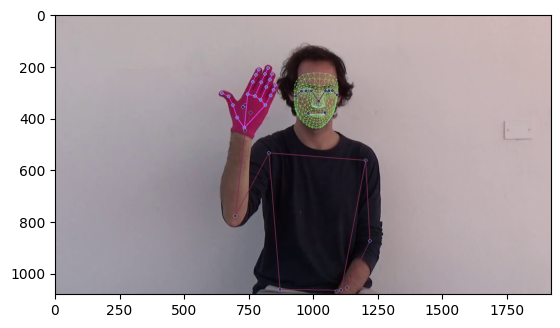

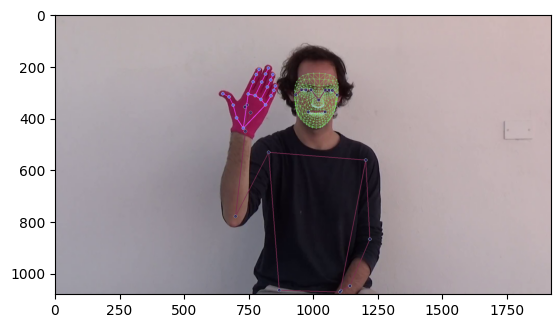

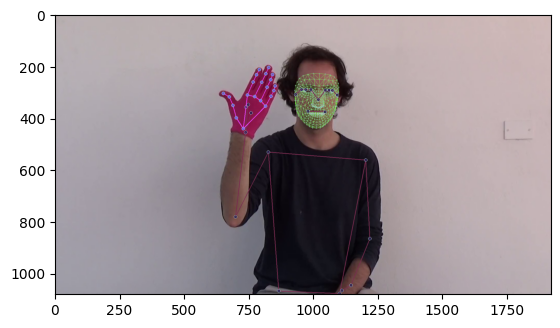

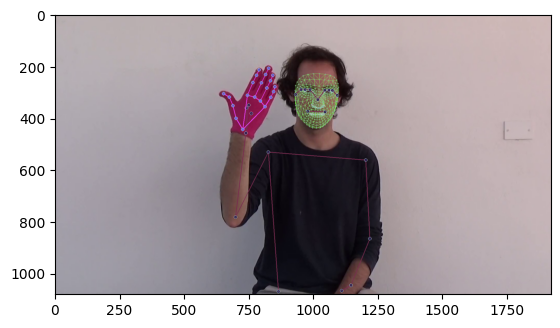

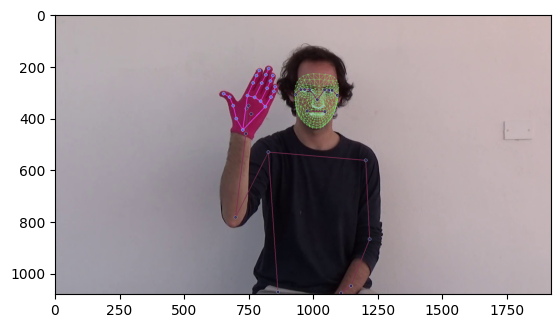

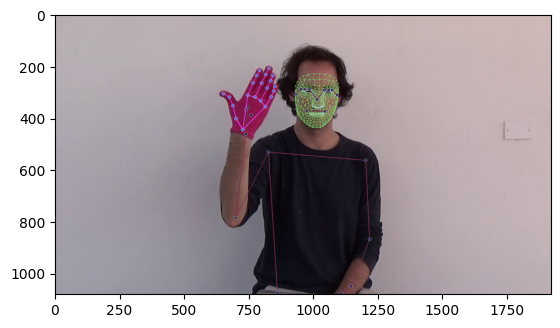

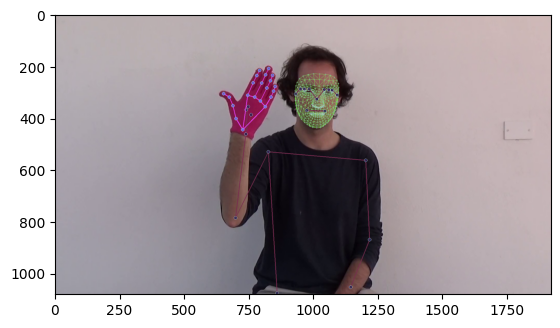

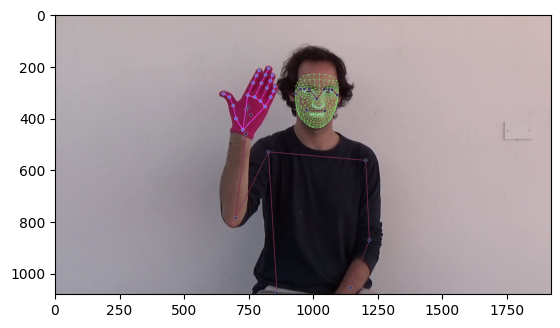

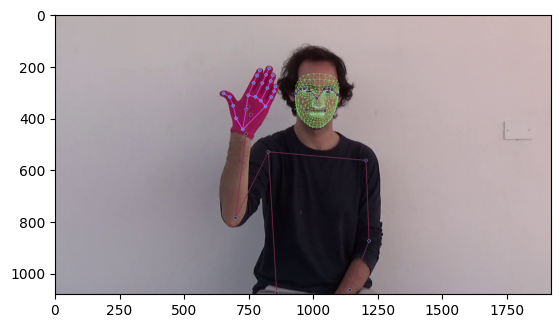

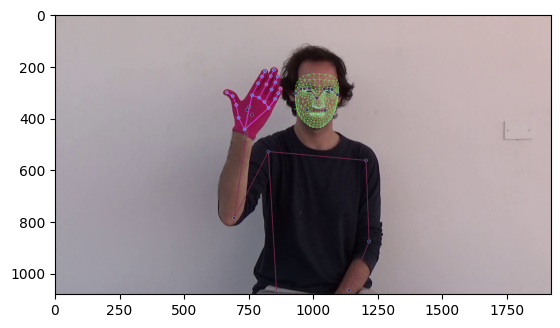

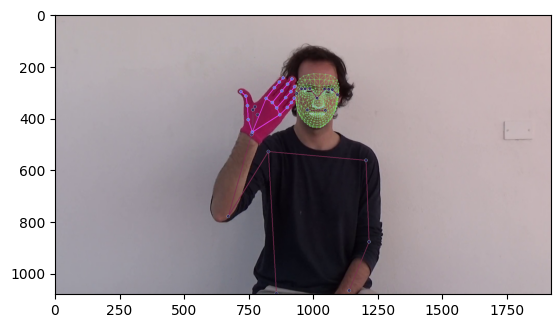

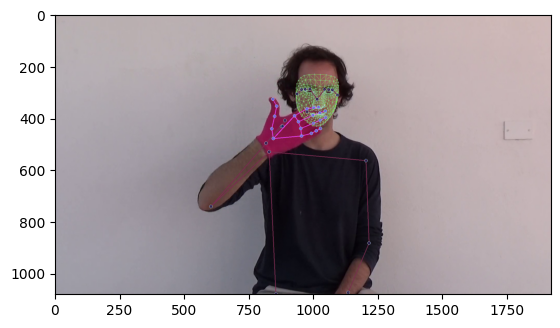

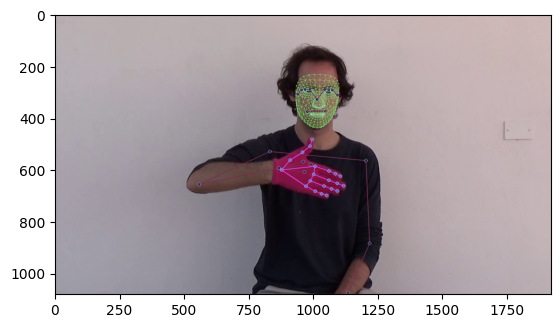

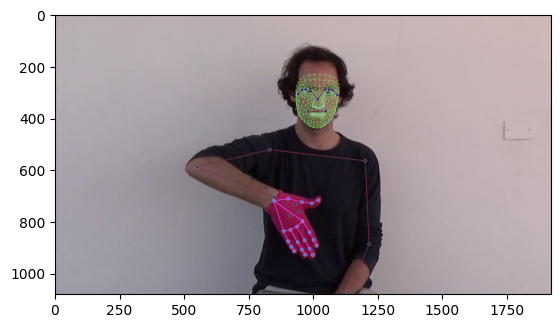

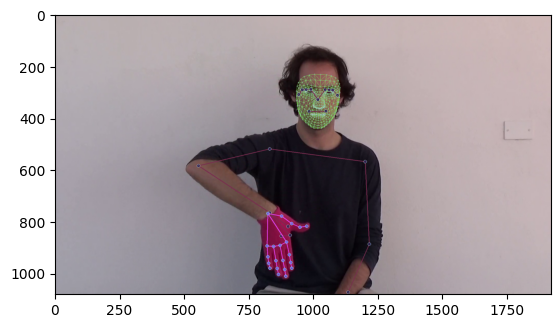

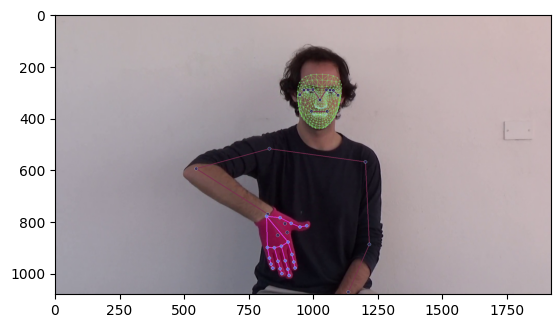

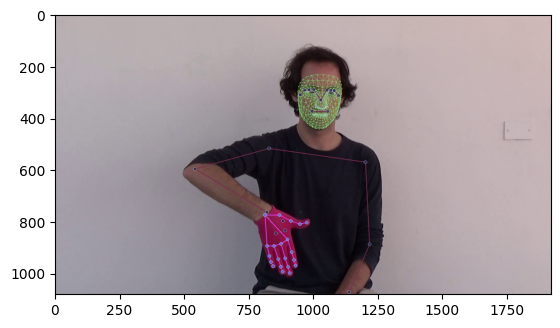

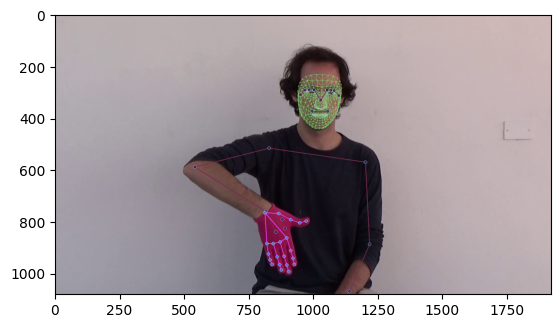

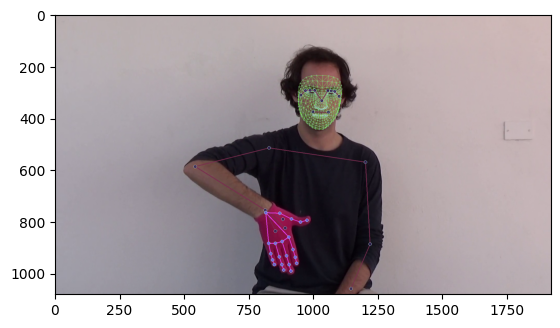

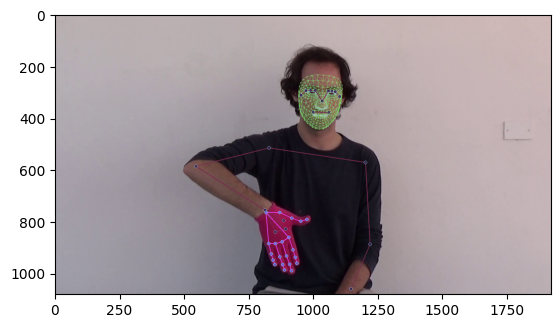

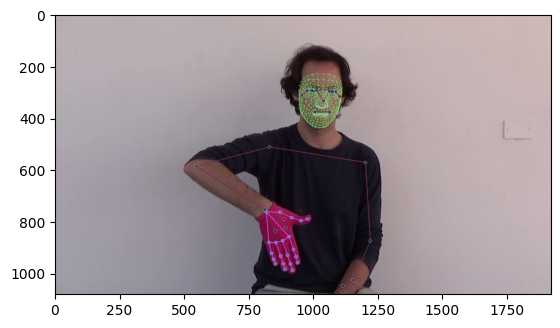

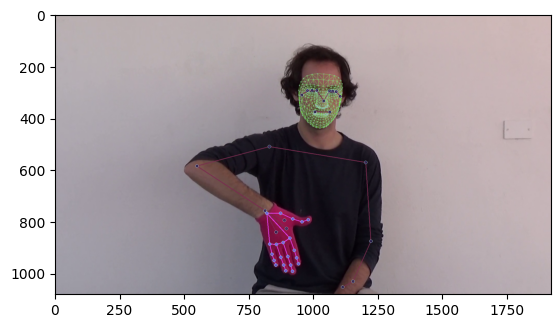

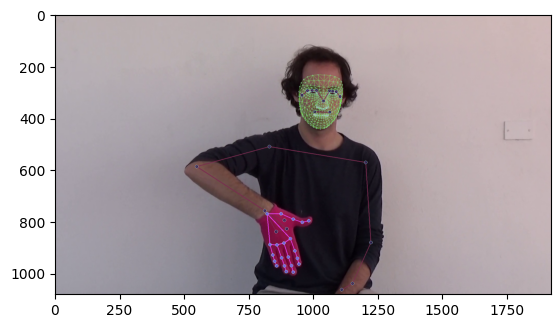

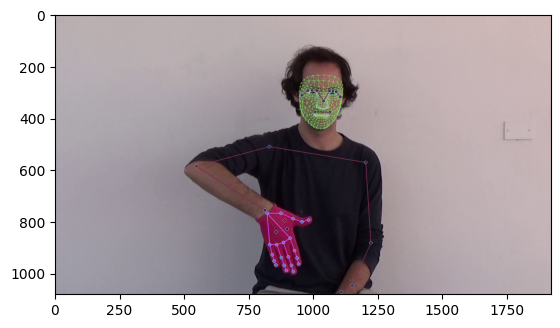

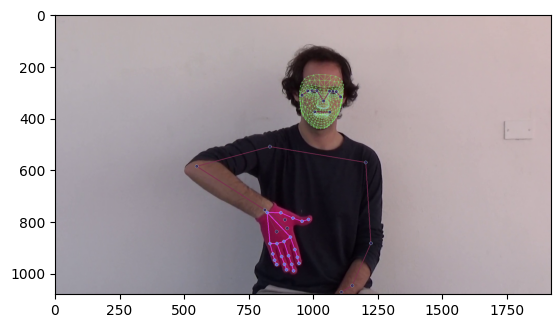

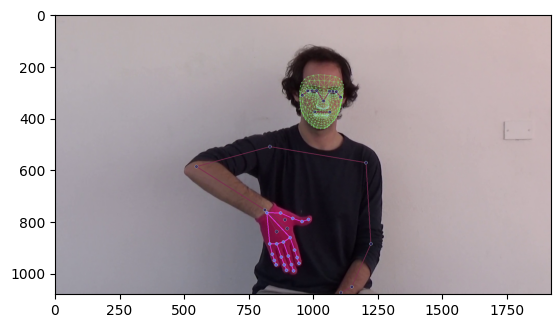

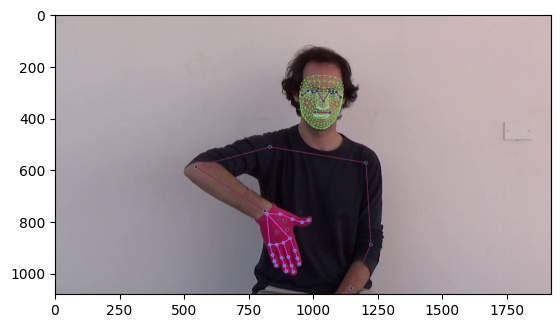

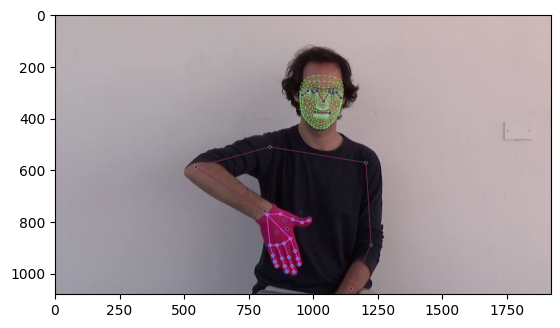

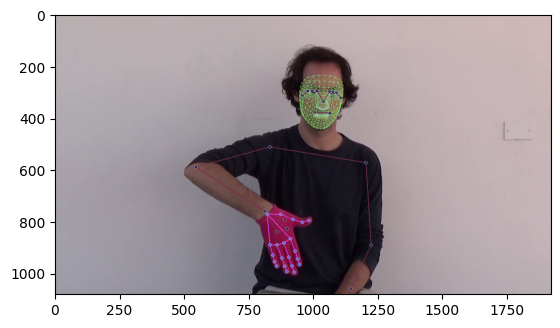

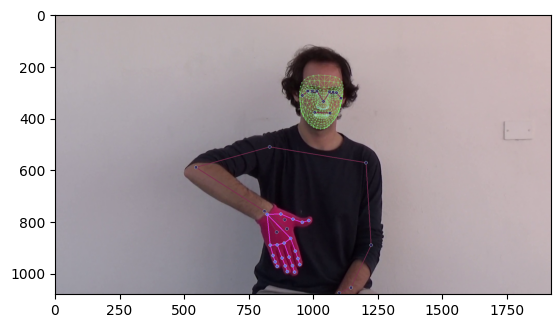

(30, 249)

In [ ]:
v= videoProc2(files[352],c=3,o=1)
v.shape

In [ ]:
v[24].max(),v[20].max(),

(2.053763382103222, 2.0776148221033983)

In [ ]:
v[25].std(),v[25].mean()

(0.8642791254737334, -2.318538043393901e-17)

In [ ]:
sum = 0
for i in range(0,1600,10):
  v= videoProc2(files[i],c=3,o=0)
  sum+=v.shape[0]
  print(v.shape,int(i/50))


In [ ]:
sum/(10*5)

43.2

In [ ]:
l=0
X_train=[]
X_dev=[]
y_train=[]
y_dev=[]
files_ = files[1600:]
for f in files_:
    v= videoProc2(f,c=3,o=0)
    p = int(f.split('/')[-1].split('_')[1])
    if p <10:
      X_train.append(v)
      label = int(f.split('/')[-1].split('_')[0])-1
      y_train.append(label)
    else:
      X_dev.append(v)
      label = int(f.split('/')[-1].split('_')[0])-1
      y_dev.append(label)


    print(p, l)
    l+=1

    

1 0
1 1
1 2
1 3
1 4
2 5
2 6
2 7
2 8
2 9
3 10
3 11
3 12
3 13
3 14
4 15
4 16
4 17
4 18
4 19
5 20
5 21
5 22
5 23
5 24
6 25
6 26
6 27
6 28
6 29
7 30
7 31
7 32
7 33
7 34
8 35
8 36
8 37
8 38
8 39
9 40
9 41
9 42
9 43
9 44
10 45
10 46
10 47
10 48
10 49
1 50
1 51
1 52
1 53
1 54
2 55
2 56
2 57
2 58
2 59
3 60
3 61
3 62
3 63
3 64
4 65
4 66
4 67
4 68
4 69
5 70
5 71
5 72
5 73
5 74
6 75
6 76
6 77
6 78
6 79
7 80
7 81
7 82
7 83
7 84
8 85
8 86
8 87
8 88
8 89
9 90
9 91
9 92
9 93
9 94
10 95
10 96
10 97
10 98
10 99
1 100
1 101
1 102
1 103
1 104
2 105
2 106
2 107
2 108
2 109
3 110
3 111
3 112
3 113
3 114
4 115
4 116
4 117
4 118
4 119
5 120
5 121
5 122
5 123
5 124
6 125
6 126
6 127
6 128
6 129
7 130
7 131
7 132
7 133
7 134
8 135
8 136
8 137
8 138
8 139
9 140
9 141
9 142
9 143
9 144
10 145
10 146
10 147
10 148
10 149
1 150
1 151
1 152
1 153
1 154
2 155
2 156
2 157
2 158
2 159
3 160
3 161
3 162
3 163
3 164
4 165
4 166
4 167
4 168
4 169
5 170
5 171
5 172
5 173
5 174
6 175
6 176
6 177
6 178
6 179
7 180
7 181
7 1

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

In [ ]:
X_train.shape,y_train.shape,X_dev.shape,y_dev.shape

((1440, 30, 249), (1440,), (160, 30, 249), (160,))

In [ ]:
np.save("./X_train_2.npy",X_train)
np.save("./y_train_2.npy",y_train)
np.save("./X_dev_2.npy",X_dev)
np.save("./y_dev_2.npy",y_dev)

In [ ]:
del files
del file_list

***
***
***

In [ ]:
# vids = vids[0:1600,:,:]
# vids = np.concatenate([vids[:,:,0::3],vids[:,:,1::3],],axis=0)
# labels = labels[0:1600]
X_train = np.load("./X_train_1.npy")
y_train = np.load("./y_train_1.npy")
X_dev = np.load("./X_dev_1.npy")
y_dev = np.load("./y_dev_1.npy")

In [ ]:
X_train2 = np.load("./X_train_2.npy")
y_train2 = np.load("./y_train_2.npy")
X_dev2 = np.load("./X_dev_2.npy")
y_dev2 = np.load("./y_dev_2.npy")

In [ ]:
X_train = np.concatenate([X_train,X_train2],axis=0)
y_train = np.concatenate([y_train,y_train2],axis=0)
X_dev = np.concatenate([X_dev,X_dev2],axis=0)
y_dev = np.concatenate([y_dev,y_dev2],axis=0)


In [ ]:
del X_train2
del y_train2
del X_dev2
del y_dev2

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=13)

X_dev, y_dev = shuffle(X_dev,  y_dev, random_state=13)

In [ ]:
X_train[1,20].mean(),X_train[1,20].std(),X_train.shape

(-6.777265049920635e-17, 0.7028325546467517, (2880, 30, 249))

In [ ]:
X_train[3].min(),X_train[3].max(),X_train[3].shape

(-2.6288368301434084, 3.0293267139840134, (30, 249))

In [ ]:
y_train[0:10],y_train.min(),y_train.max(),y_train.shape

(array([23,  9, 54, 40, 57,  0,  6, 17, 31,  4]), 0, 63, (2880,))

In [ ]:

# Bidirectional(GRU(128, return_sequences=True, activation='tanh')),
# BatchNormalization(axis=-1,center=True,scale=True,),
# ReLU(), 
# LSTM
# tf.keras.layers.SimpleRNN(256, return_sequences=True, activation="relu",),


# Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.05)),  
# # Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.05)),  
# BatchNormalization(axis=-1,center=True,scale=True,),

model_lstm_1 = Sequential([
tf.keras.Input(shape=(30,249),),


GRU(96, return_sequences=False, activation="relu",),
BatchNormalization(axis=-1,center=True,scale=True,),
Dropout(0.25),


Dense(64, activation='softmax')
])


In [ ]:
model_lstm_1.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 96)                99936     
                                                                 
 batch_normalization_27 (Bat  (None, 96)               384       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 96)                0         
                                                                 
 dense_27 (Dense)            (None, 64)                6208      
                                                                 
Total params: 106,528
Trainable params: 106,336
Non-trainable params: 192
_________________________________________________________________


In [ ]:
model_lstm_1.compile(tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,epsilon=1e-07,)
        ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
            ,metrics=["accuracy",])

In [ ]:
model_lstm_1.fit(X_train, y_train, epochs=20, batch_size=128, )#batch_size=64 ,#validation_data=(X_dev, y_dev)

Epoch 1/20
23/23 [==============================] - 5s 75ms/step - loss: 3.6483 - accuracy: 0.1497
Epoch 2/20
23/23 [==============================] - 2s 74ms/step - loss: 2.3115 - accuracy: 0.4722
Epoch 3/20
23/23 [==============================] - 2s 76ms/step - loss: 1.6199 - accuracy: 0.6615
Epoch 4/20
23/23 [==============================] - 2s 74ms/step - loss: 1.0116 - accuracy: 0.8299
Epoch 5/20
23/23 [==============================] - 2s 75ms/step - loss: 0.6090 - accuracy: 0.9243
Epoch 6/20
23/23 [==============================] - 2s 105ms/step - loss: 0.3742 - accuracy: 0.9608
Epoch 7/20
23/23 [==============================] - 3s 143ms/step - loss: 0.2485 - accuracy: 0.9840
Epoch 8/20
23/23 [==============================] - 2s 80ms/step - loss: 0.1804 - accuracy: 0.9861
Epoch 9/20
23/23 [==============================] - 2s 75ms/step - loss: 0.1371 - accuracy: 0.9931
Epoch 10/20
23/23 [==============================] - 2s 76ms/step - loss: 0.1135 - accuracy: 0.9944
Epoch 1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-264-2f2391d47f67>", line 1, in <cell line: 1>
    model_lstm_1.fit(X_train, y_train, epochs=20, batch_size=128, )#batch_size=64 ,#validation_data=(X_dev, y_dev)
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-264-2f2391d47f67>", line 1, in <cell line: 1>
    model_lstm_1.fit(X_train, y_train, epochs=20, batch_size=128, )#batch_size=64 ,#validation_data=(X_dev, y_dev)
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 894, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/l

In [ ]:
model_lstm_1.evaluate(X_train, y_train)

90/90 [==============================] - 2s 15ms/step - loss: 0.0120 - accuracy: 0.9997


[0.012017187662422657, 0.9996528029441833]

In [ ]:
model_lstm_1.evaluate(X_dev, y_dev)

10/10 [==============================] - 0s 14ms/step - loss: 0.1866 - accuracy: 0.9469


[0.1865713894367218, 0.9468749761581421]

In [ ]:
model_lstm_1.save("./modelArgantine/v8_64_4")

In [ ]:
path ="./testdata/"
file_list = os.listdir(path)
file_list.sort()

files = [path+"/"+f for f in file_list]# 
files[0],files[1]

('./testdata//Away.MP4', './testdata//Bitter.MP4')

In [ ]:
test1 = {}
j=0
for i in file_list:
  v=videoProc2(files[j],c=1,o=0)
  test1[i]=v
  print(j)
  j+=1

In [ ]:
test2 = {}
j=0
for i in file_list:
  v=videoProc2(files[j],c=2,skip=0,o=0)
  test2[i]=v
  print(j)
  j+=1

In [ ]:
# reconstructed_model = tf.keras.models.load_model("./modelArgantine/v8.6")

In [ ]:
# reconstructed_model.summary()

In [ ]:
for l,v in test1.items():#model_lstm_1
  p = model_lstm_1.predict(np.reshape(v, (1,30,249)))
  pp =np.argmax(p)
  print(l,pp,p[:,pp])

1/1 [==============================] - 0s 235ms/step
Away.MP4 12 [0.9167037]
1/1 [==============================] - 0s 27ms/step
Bitter.MP4 41 [0.19868895]
1/1 [==============================] - 0s 29ms/step
Born.MP4 14 [0.90647703]
1/1 [==============================] - 0s 30ms/step
Bright.mp4 39 [0.91140586]
1/1 [==============================] - 0s 26ms/step
Call.MP4 16 [0.9572964]
1/1 [==============================] - 0s 26ms/step
Colors.MP4 45 [0.3962879]
1/1 [==============================] - 0s 30ms/step
Drawer.MP4 61 [0.8786825]
1/1 [==============================] - 0s 32ms/step
Enemy.MP4 9 [0.72751087]
1/1 [==============================] - 0s 27ms/step
Green.MP4 2 [0.9397495]
1/1 [==============================] - 0s 29ms/step
Learn.MP4 15 [0.34038198]
1/1 [==============================] - 0s 28ms/step
Light-blue.MP4 5 [0.9131156]
1/1 [==============================] - 0s 26ms/step
Man.MP4 11 [0.19648935]
1/1 [==============================] - 0s 41ms/step
Opaque.MP4 0 [0.

In [ ]:
for l,v in test2.items():#model_lstm_1
  p = model_lstm_1.predict(np.reshape(v, (1,30,249)))
  pp =np.argmax(p)
  print(l,pp,p[:,pp])

1/1 [==============================] - 0s 27ms/step
Away.MP4 12 [0.6527983]
1/1 [==============================] - 0s 27ms/step
Bitter.MP4 61 [0.54927456]
1/1 [==============================] - 0s 27ms/step
Born.MP4 14 [0.9615698]
1/1 [==============================] - 0s 29ms/step
Bright.mp4 39 [0.38280833]
1/1 [==============================] - 0s 26ms/step
Call.MP4 16 [0.18992457]
1/1 [==============================] - 0s 25ms/step
Colors.MP4 6 [0.4688838]
1/1 [==============================] - 0s 26ms/step
Drawer.MP4 13 [0.70296484]
1/1 [==============================] - 0s 33ms/step
Enemy.MP4 9 [0.94428533]
1/1 [==============================] - 0s 34ms/step
Green.MP4 2 [0.97169757]
1/1 [==============================] - 0s 33ms/step
Learn.MP4 15 [0.21160054]
1/1 [==============================] - 0s 26ms/step
Light-blue.MP4 5 [0.75483567]
1/1 [==============================] - 0s 27ms/step
Man.MP4 61 [0.6365057]
1/1 [==============================] - 0s 26ms/step
Opaque.MP4 58 [0

In [ ]:
test2["Bright.mp4"][25].max()

2.5986592531243486